# Analysis on Factors Influencing Bitcoin Price

# <font color=red> Road map </font>
1. Get related dataset from 
    - Obtain Tweets textual data from Kaggle ( With timestamp )
    - Obtain financial data from "yahoo finance"
        - BTC Open, Close, volumn, high, low ( Granularity: 1mins )
        - Oil price
        - USD currency 
        - Gold price
        - Related CropytoCurrency price, volumn, high, low (["BCH", "ETH","LTC"])
  

2. BTC price
    - EDA
    - Feature Engineering 
        - Preprocessing: get basic log return 
        - Technical analysis indicators
        - Normalization - MinMax
        
    - Benchmark Model:
        - Moving Average
        - ARIMA
    - Evaluation 
        - 20% testing set
        - mae 
    ---
    - NN Dataset generating
    - NN Models
        - MLP (multilayer perceptron)
        - naive_RNN
        - Bidirection GRU
        - LSTM
        - Seq2Seq = Autoencoder
    - Evaluation 
        - 20% testing set
        - MAE
    ---

3. Related information
    - Oil price
    - USD currency 
    - Gold price
    - Related CropytoCurrency price, volumn, high, low (["BCH", "ETH","LTC"])


4. Further analysis
    - Event driving?
    - possible related information taking account in the future


5. Trading policy (not do yet)

# Data Prepare

## get dataset

In [92]:
# !pip install mplfinance
# !pip install pandas_datareader
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
from collections import Counter, defaultdict

from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer  # 如果有这个, NLTK的preprocessing可以不用做
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMAResults
import datetime
import glob
import keras

import matplotlib.pyplot as plt   # Import matplotlib
import mplfinance
import nltk
import numpy as np
import pandas as pd
import pandas_datareader.data as web   
import random
import seaborn as sns
import statsmodels as st
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsatl  
import re, string, os 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


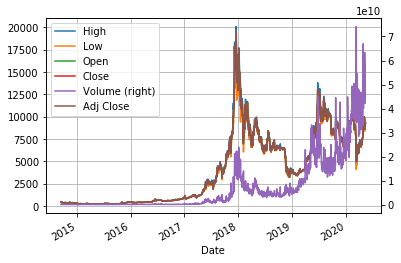

In [93]:

start = datetime.datetime(2010,1,1)
end = datetime.date.today()


BTC = web.DataReader("BTC-USD", "yahoo", start, end) # 可以选择信息源
BTC.plot(secondary_y = ["Volume"], grid = True) 


## EDA

Populating the interactive namespace from numpy and matplotlib


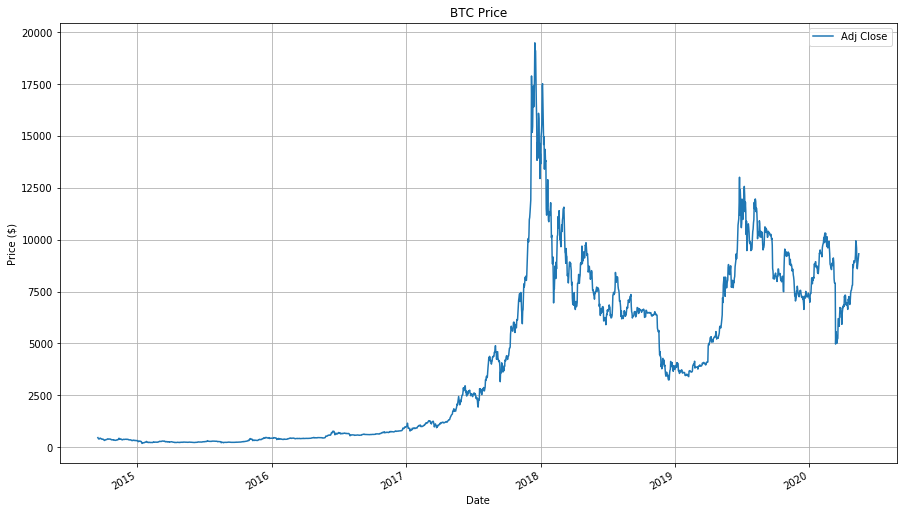

In [94]:

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
BTC["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL
plt.title('BTC Price')
plt.ylabel('Price ($)')
plt.legend()

# ARIMA Models

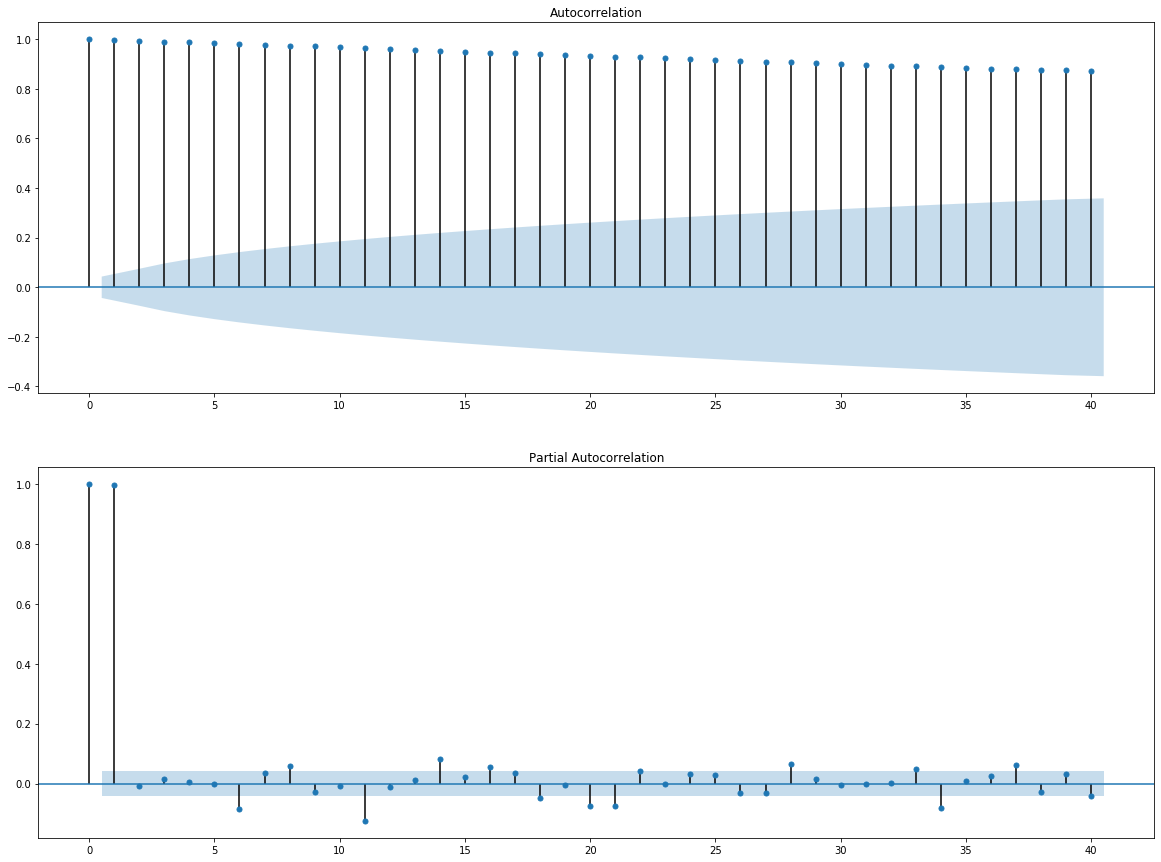

In [95]:



a = BTC[['Close']]

def preview_f(a, lag=None):

    series = a
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    plot_acf(series,lags=lag, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(series,lags=lag, ax=plt.gca())
    plt.show()
    
    return None

preview_f(a, lag=40)

##  AR order selection

In [96]:
mod = st.tsa.ar_model.ar_select_order(a,maxlag=30,ic='bic',glob=False,trend='c',
                                   seasonal=False,exog=None,hold_back=None,period=None,missing='none')


print("ar order: ", mod.ar_lags)
mod.bic

ar order:  [1]


{(1,): 11.33812265077214,
 (1, 2): 11.341252193792917,
 (1, 2, 3): 11.344876578681681,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11): 11.34574732751597,
 (1, 2, 3, 4): 11.348522729422085,
 (1, 2, 3, 4, 5, 6): 11.348898386635216,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12): 11.349487460929607,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14): 11.350717377644798,
 (1, 2, 3, 4, 5, 6, 7): 11.350770042718024,
 (1, 2, 3, 4, 5): 11.35171554884897,
 (1, 2, 3, 4, 5, 6, 7, 8): 11.352908286768082,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13): 11.35305326860755,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15): 11.354117390291195,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 11.355244250177714,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16): 11.357169381914888,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 11.358749559463481,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17): 11.359571371483476,
 (1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16

##  SARIMA Model

In [97]:
from statsmodels.tsa.arima_model import ARIMA
# seasonal models: SARIMA(P, D, Q, s)
mod = ARIMA(a, order=(1, 0, 0))
res = mod.fit(method='css-mle',disp=5)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2066
Model:                     ARMA(1, 0)   Log Likelihood              -14624.324
Method:                       css-mle   S.D. of innovations            286.674
Date:                Wed, 13 May 2020   AIC                          29254.648
Time:                        23:00:57   BIC                          29271.548
Sample:                             0   HQIC                         29260.843
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4434.0721   2182.769      2.031      0.042     155.923    8712.221
ar.L1.Close     0.9975      0.001    690.452      0.000       0.995       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0025           +0.0000j            1.0025            0.0000
-----------------------------------------------------------------------------
"""

##  residual checking
- 做evaluation的时候, 需要另外独立创造数据

                 0
count  2066.000000
mean      1.404850
std     299.733673
min   -3976.738127
25%     -21.915143
50%      -7.799408
75%      30.439853
max    3632.505546


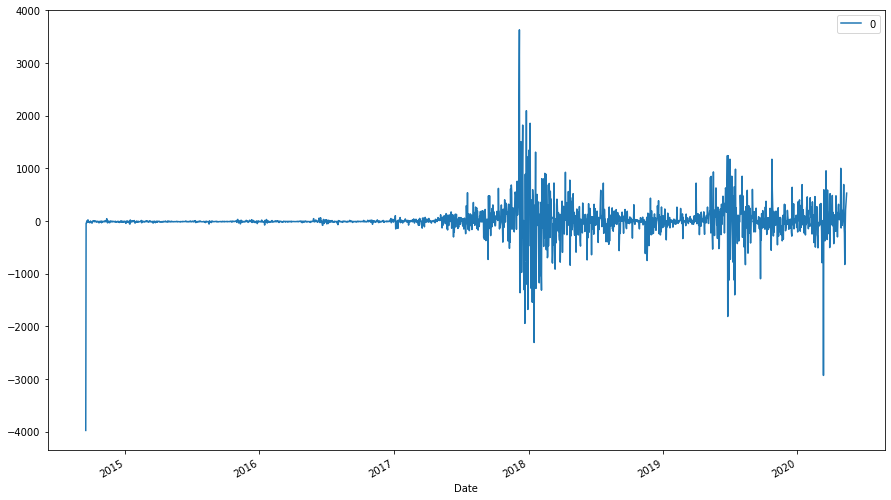

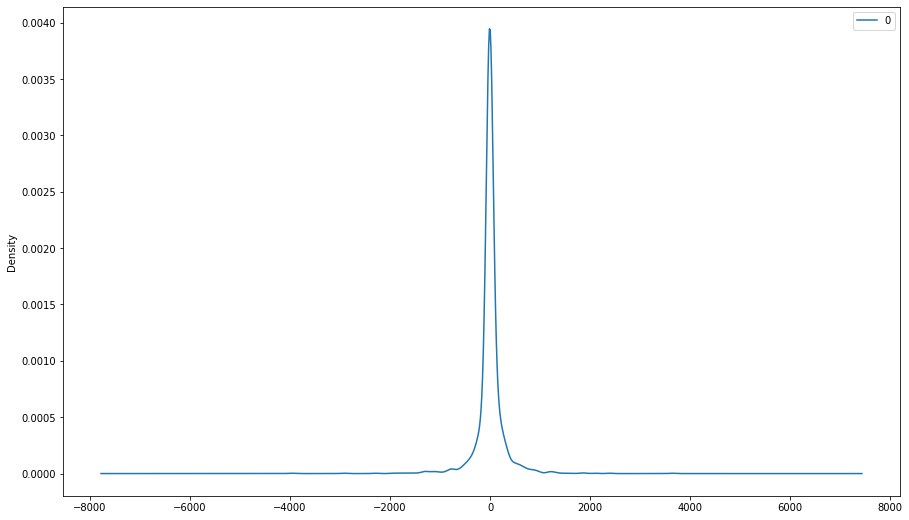

In [98]:
# plot residual errors
residuals = pd.DataFrame(res.resid)
residuals.plot()
residuals.plot(kind="kde")
print(residuals.describe())


### Residual Norm test
- 不通过, 因为数据并没有标准化, residual 明显存在比较大的 mean 和std

In [99]:
from scipy.stats import kstest, anderson, shapiro
x = res.resid
# x = np.random.randn(100000)
kstest(x, 'norm') # pvalue 越高, 越说明是标准正态分布
# shapiro(x)
# anderson(x)

KstestResult(statistic=0.5941575259464418, pvalue=0.0)

##  Outliers remove & Manually Tuning
- 差分是有lag的, 这样能找到 seasonal 规律
- 做一阶差分 (I 次), 检验满足平稳性, 寻找I参数
- 删除outliers 

ADF Statistic: -8.269438
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


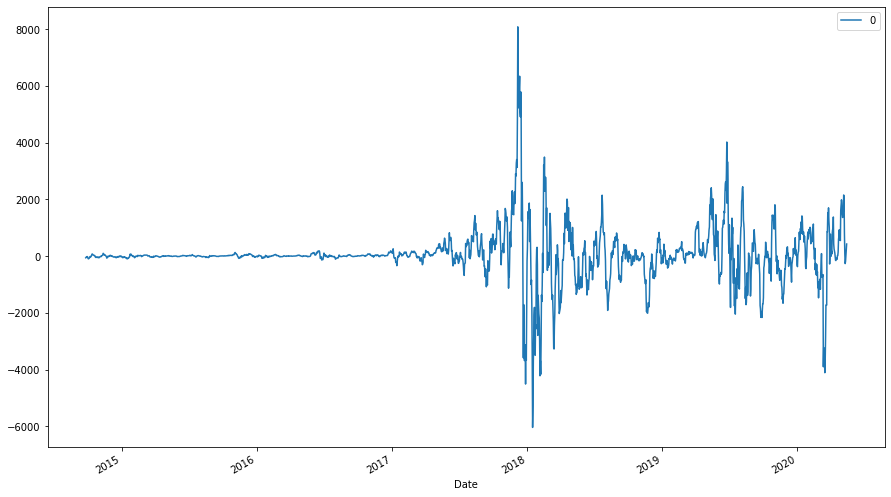

The best seasonal difference:  None
ADF Statistic: -8.681494
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


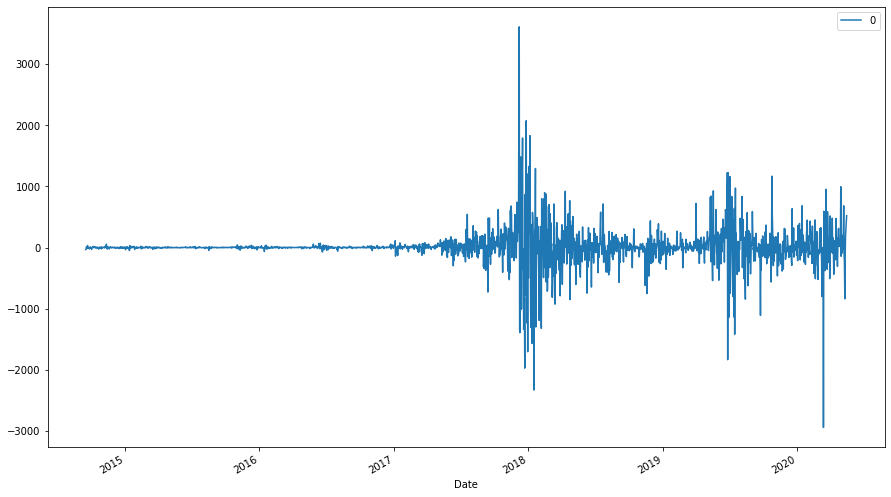

ADF Statistic: -14.081743
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


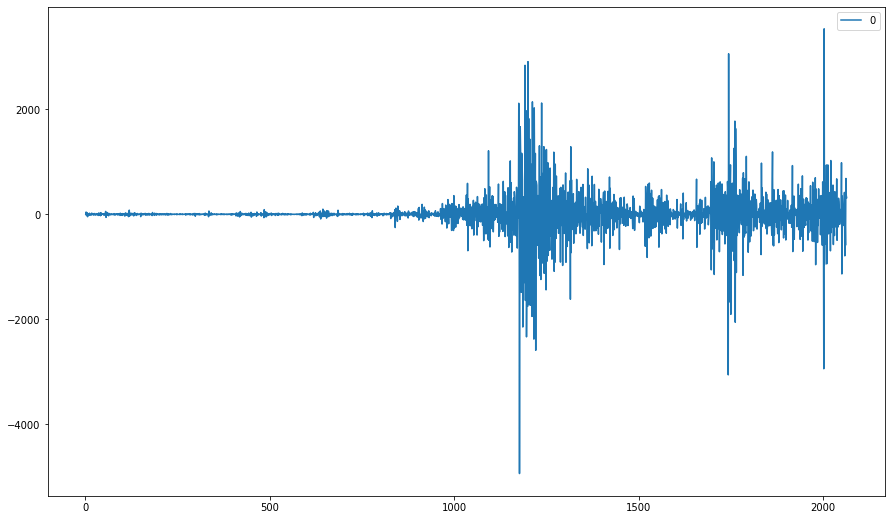

ADF Statistic: -19.675303
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


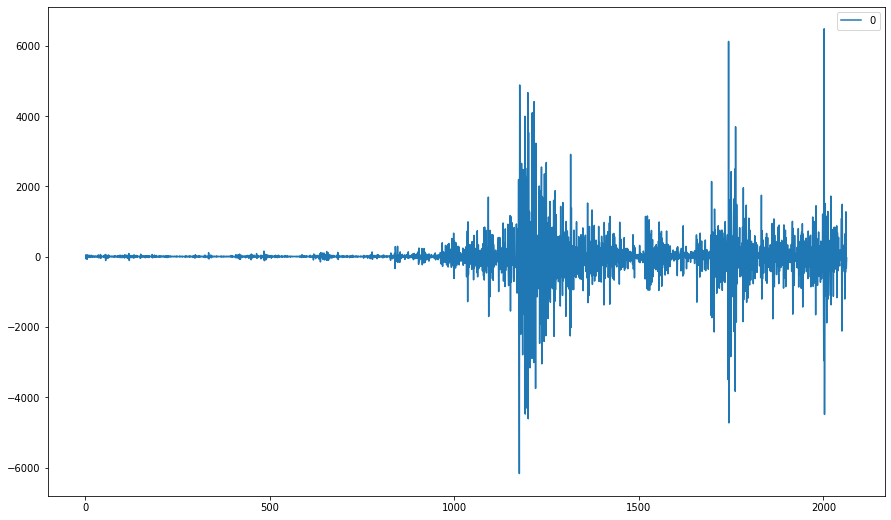

ADF Statistic: -23.344640
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


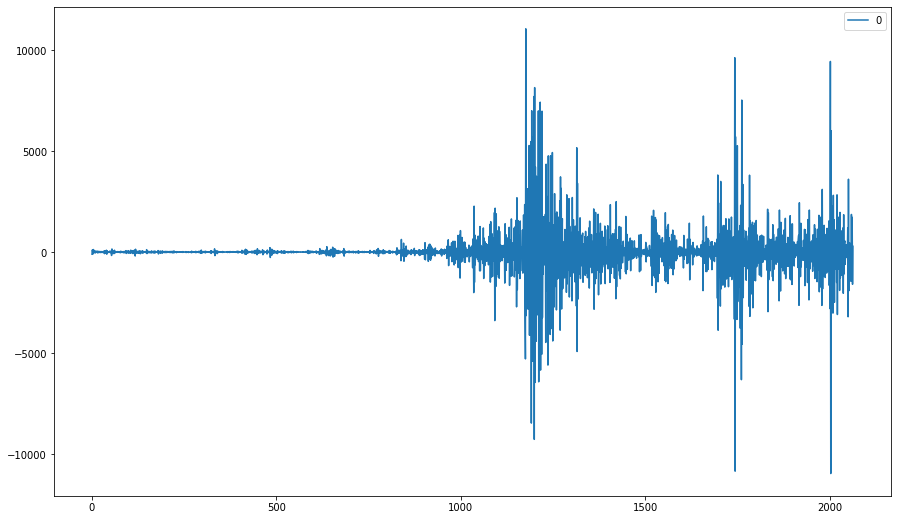

The best difference order:  None


In [100]:
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
#     return numpy.array(diff)
    return pd.DataFrame(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]







def stationary_test(a , interval = 12):
    X = a.values.reshape(-1,1)
    stationary = difference(X, interval)
    stationary.index = a.index[interval:]
    # check if stationary
    result = adfuller(stationary)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    stationary.plot()
    plt.show()
    
    return stationary.reset_index(drop=True)





############ 删除outliers
a = BTC[['Close']]
# 查看周期性
stationary_test(a, interval = 10)
print("The best seasonal difference: " , None )

b = a.copy()

############ 确认 I 参数
for _ in range(1, 5):
    b = stationary_test(b, interval = 1)
    
print("The best difference order: " , None )

## Refined Model & Prediction

In [102]:
import warnings
from math import sqrt
import numpy
from tqdm import tnrange, tqdm_notebook


def score( y, y_hat ):
    ae = list(map(lambda i: np.abs(y[i] - y_hat[i]) , range(len(y_hat)))) # abs error for one sample cross every features
    mae = np.mean(ae, axis=0)[0] # average error
    
    mse = mean_squared_error(y, y_hat)
    rmse = sqrt(mse)
    return mae, rmse
    
    
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def fit_train_arima_model(X, arima_order, interval = 7, bias = 0):
    
    # prepare training dataset
    X = X.values
    train_ratio = 0.8
    train, test = X[0:int(len(X) *train_ratio)], X[int(len(X) *train_ratio):]

    history = list(train)
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        # seasonal
        diff = difference(history, interval)
        model = ARIMA(diff, order=arima_order) # fitting to get parameters
        model_fit = model.fit(trend='nc', maxiter=50, solver='lbfgs', disp=0)  # 这里决定了效率
        yhat = model_fit.forecast(steps=1)[0]  # prediction
        yhat = bias + inverse_difference(history, yhat, interval)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mae, rmse = score(test, predictions)
    return mae, rmse, predictions, test


# evaluate combinations of p, d and q values for an ARIMA model
def grid_models(dataset, p_values, d_values, q_values, bias=0, interval = 7):
    dataset = dataset.astype('float32')
    best_score_rmse, best_cfg = float("inf"), None
    for p in tqdm_notebook(p_values):
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae, rmse,_,_ = fit_train_arima_model(dataset, order, interval = interval, bias = bias)
                    if rmse < best_score_rmse:
                        best_score_mae, best_score_rmse, best_cfg = mae, rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f, MAE=%.3f' % (best_cfg, best_score_rmse, best_score_mae))
    return best_score_mae, best_score_rmse, best_cfg

##  Grid-Search

In [ ]:

# load dataset
series = a
# evaluate parameters
# p_values = range(0, 8)
# d_values = range(0, 4)
# q_values = range(0, 4)

p_values = [5]
d_values = [0]
q_values = [3]
warnings.filterwarnings("ignore")

############# Training ignore
best_score_mae, best_score_rmse, best_cfg = grid_models(series, p_values, d_values, q_values, bias=0, interval = 7)

In [ ]:
print("best_score_mae",best_score_mae)
print("best_score_rmse",best_score_rmse)
print("best_cfg",best_cfg)

### Best model Residual  =  [5,0,3]

In [5]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p,d,q, bias=0, interval = 7):
    dataset = dataset.astype('float32')
    order = (p,d,q)
    mae, rmse, predictions, test = fit_train_arima_model(dataset, order, interval = interval, bias = bias)
    best_score_mae, best_score_rmse, best_cfg = mae, rmse, order

    print('Best ARIMA%s RMSE=%.3f, MAE=%.3f' % (best_cfg, best_score_rmse, best_score_mae))
    return best_score_mae, best_score_rmse,  predictions, test 

series = a
# best_cfg = [5,0,3]
est_score_mae, best_score_rmse,  predictions, test  = evaluate_models(series, best_cfg[0], best_cfg[1], best_cfg[2] , bias=0, interval = 7)

In [ ]:
def residuals_plot(test, predictions):
    # errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    # plot
    plt.figure()
    plt.subplot(211)
    residuals.hist(ax=plt.gca())
    plt.subplot(212)
    residuals.plot(kind='kde', ax=plt.gca())
    plt.show()
    return residuals

resid = residuals_plot(test, predictions )

kstest(resid, 'norm') 
# shapiro(resid)
# anderson(resid)

### <font color= red>  Final parameters setting </font>

In [ ]:
resid.describe()
bias =  np.mean(resid.values)
print("mean of resid: ",bias)
# arima_order = [5,0,3]

### Bias term Adjustment
- get the bias term value = mean of residual
- print(residuals.describe())

In [ ]:
mae, rmse, predictions, test = evaluate_models(series, arima_order[0],arima_order[1], arima_order[2] , bias=bias) 
resid = residuals_plot(test, predictions )

### Final ARIMA Model

In [1]:
# prepare training dataset
X = a.values
train_ratio = 0.8
train, test = X[0:int(len(X) *train_ratio)], X[int(len(X) *train_ratio):]
history = list(train)
interval = 7

diff = difference(history, interval)
model = ARIMA(diff, order=arima_order) # fitting to get parameters
model_fit = model.fit(trend='nc', maxiter=500, solver='lbfgs', disp=0)

############# Save best model
model_fit.save('model_arima.pkl')
np.save('model_arima_bias.npy', [bias])


In [ ]:
model_fit.summary()

## One step prediction

In [105]:
series = a
# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
interval = 7
model_fit = ARIMAResults.load('model_arima.pkl')
bias = np.load('model_arima_bias.npy')
yhat = float(model_fit.forecast(steps=1)[0])
yhat = bias + inverse_difference(series.values, yhat, 7)
print('Predicted: %.3f' % yhat)

Predicted: 9880.110


In [106]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                 1645
Model:                     ARMA(5, 3)   Log Likelihood              -11866.377
Method:                       css-mle   S.D. of innovations            327.293
Date:                Wed, 13 May 2020   AIC                          23750.754
Time:                        23:01:13   BIC                          23799.403
Sample:                             0   HQIC                         23768.794
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.0        1.1884      0.042     28.134      0.000       1.106       1.271
ar.L2.0       -0.1853      0.077     -2.398      0.017      -0.337      -0.034
ar.L3.0       -0.7850      0.070    -11.160      0.000      -0.923      -0.647
ar.L4.0        0.8114      0.044     18.250      0.000       0.724       0.898
ar.L5.0       -0.2922      0.024    -12.075      0.000      -0.340      -0.245
ma.L1.0       -0.3365      0.037     -9.094      0.000      -0.409      -0.264
ma.L2.0       -0.1116      0.046     -2.437      0.015      -0.201      -0.022
ma.L3.0        0.8994      0.037     24.380      0.000       0.827       0.972
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0769           -0.0000j            1.0769           -0.5000
AR.2            0.6283           -1.1291j            1.2921           -0.1692
AR.3            0.6283           +1.1291j            1.2921            0.1692
AR.4            1.2985           -0.4662j            1.3796           -0.0549
AR.5            1.2985           +0.4662j            1.3796            0.0549
MA.1            0.6180           -0.7862j            1.0000           -0.1440
MA.2            0.6180           +0.7862j            1.0000            0.1440
MA.3           -1.1118           -0.0000j            1.1118           -0.5000
-----------------------------------------------------------------------------
"""

                 0
count  1645.000000
mean      2.751683
std     327.651705
min   -3465.397651
25%     -15.620059
50%       2.115143
75%      24.268702
max    3962.873396


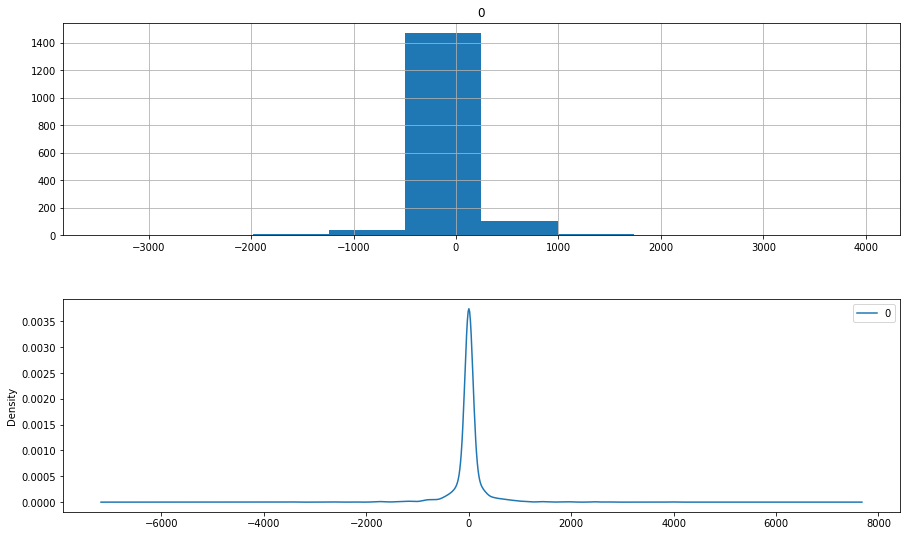

In [107]:
residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

## Rolling prediction Result on test set 
- 20% of testing data

In [3]:
# 数据序列
series = a 
bias =  np.mean(resid.values)
mae, rmse, predictions, test = fit_train_arima_model(series, arima_order, interval = 7, bias = bias)
best_orgin = pd.DataFrame(np.vstack([train, test]), index=BTC.index)
best_pred = pd.DataFrame(np.vstack([train, predictions]), index=BTC.index)

In [2]:
plt.figure(figsize=(200,50))
plt.plot(best_orgin)
plt.plot(best_pred, color='red')
plt.show()

In [ ]:
plt.figure(figsize=(200,50))
plt.plot(best_orgin[-300:])
plt.plot(best_pred[-300:], color='red')
plt.show()

# Feature engineering

## Preprocessing 


In [12]:

def get_btc(start, end): # 小写
    BTC = web.DataReader("BTC-USD", "yahoo", start, end)
    btc = BTC.copy()
    columns_lower = [i.lower() for i in list(BTC.columns)]
    btc.columns = columns_lower
    return btc


start = datetime.datetime(2010,1,1)
end = datetime.date.today()
btc = get_btc(start, end)


## Add features
btc['return'] = btc[["adj close"]].apply(lambda x: x.diff(1)/x)
# stock_return = btc.apply(lambda x: (x-x.shift(1))/x)
btc['log_return'] = btc[["adj close"]].apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.


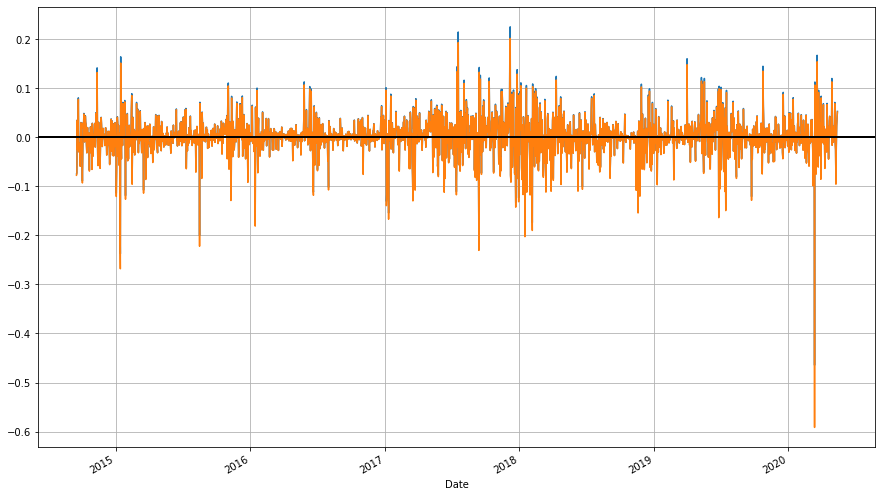

In [13]:
btc['log_return'].plot(grid = True).axhline(y = 0, color = "black", lw = 2)
btc['return'].plot(grid = True).axhline(y = 0, color = "black", lw = 2)

## <font color=red>Technical indicators</font>

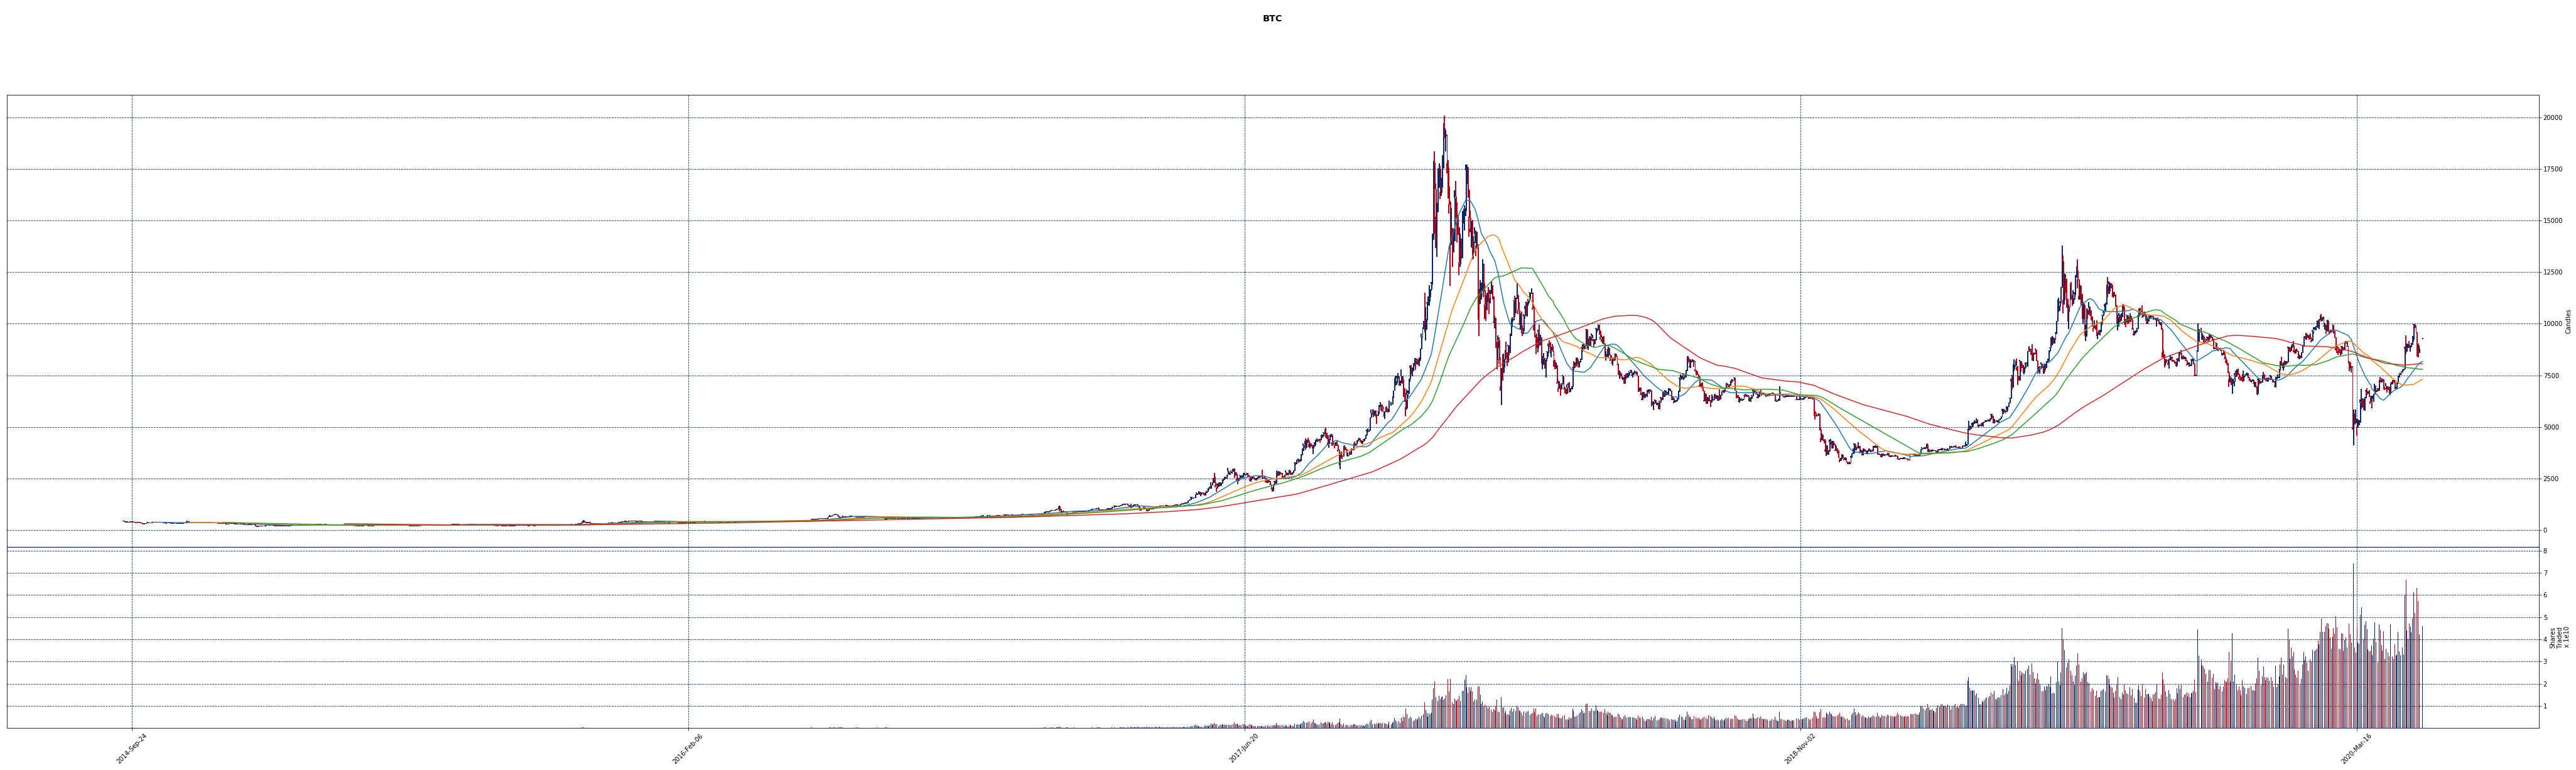

In [110]:
import mplfinance as mpf
mpf.plot(BTC, type='candle',mav=(30,60,90,200),volume=True,show_nontrading=True,
         figratio=(,20),figscale=1,
         title='\nBTC',
         ylabel='Candles',
         ylabel_lower='Shares\nTraded',
         style='starsandstripes'
        )

In [15]:
btc["macd_20d"] = np.round(btc["close"].rolling(window = 30, center = False).mean(), 4)
btc["macd_60d"] = np.round(btc["close"].rolling(window = 60, center = False).mean(), 4)
btc["macd_90d"] = np.round(btc["close"].rolling(window = 90, center = False).mean(), 4)
btc["macd_200d"] = np.round(btc["close"].rolling(window = 200, center = False).mean(), 4)
# df.rolling(2, win_type='gaussian').sum(std=3)
# df.rolling('2s').sum()
# dt = btc.dropna(how='any')


In [16]:


import datetime
import time
import pandas_datareader.data as web
import pandas as pd


def time_strf(a):
    b = time.localtime(a)
    c = time.strftime("%Y-%m-%d %H:%M:%S", b)
    return c

def process_time(BCH, agg='d'):
    BCH.index = pd.to_datetime(BCH.TimeStamp.apply(time_strf))
    BCH = BCH.drop(columns=['TimeStamp'])
    res = BCH.resample(agg).first()
    return BCH, res



def join_corr_data(dt, start, end, dt_symbol, rsuffix_name ):
    dtt = dt.copy()
    ## read & join
    for i in range(len(dt_symbol)):
        a = web.DataReader(dt_symbol[i], "yahoo", start, end)
        dtt = dtt.join(a[["Close"]], how='left',rsuffix='_'+rsuffix_name[i])
    return dtt

def get_btc(start, end): # 小写
    BTC = web.DataReader("BTC-USD", "yahoo", start, end)
    btc = BTC.copy()
    columns_lower = [i.lower() for i in list(BTC.columns)]
    btc.columns = columns_lower
    return btc





def get_ta_indicates(btc):
    #################################### 
    # 中间添加技术指标. 输入 btc table. 输出 btc_techniques table

    #a = ATR(btc, 14)
    from tqsdk.ta import ATR, CCI, PVT, EMA, ARBR, QHLSR, ROC, VRSI, OBV, PRICEOSC, ARBR

    a = ATR(btc, 14).set_index(btc.index) # 平均真实波幅
    b = CCI(btc,14).set_index(btc.index) # 顺势指标
    c = PVT(btc).set_index(btc.index)
    d = EMA(btc,7).set_index(btc.index) # 指数加权移动平均线
    # e = ARBR(btc,7).set_index(btc.index) #人气意愿指标
    f = QHLSR(btc).set_index(btc.index) # 阻力指标
    g = ROC(btc,7,7).set_index(btc.index)# 变动速率
    # h = VRSI(btc, 7)# 量相对强弱
    i = OBV(btc).set_index(btc.index) # 能量潮
    j = PRICEOSC(btc, 30,7).set_index(btc.index) # 价格震荡指数
    # k = ARBR(btc, 7).set_index(btc.index) # 人气意愿指标
    btc_techniques = pd.concat([btc,a,b,c,d,f,g,i,j], axis=1)
    return btc_techniques


######################################

start = datetime.datetime(2010,1,1)
end = datetime.date.today()

btc = get_btc(start, end)
btc_techniques = get_ta_indicates(btc)


ml_data = btc_techniques.dropna(how='any')
ml_data

在使用天勤量化之前，默认您已经知晓并同意以下免责条款，如果不同意请立即停止使用：https://www.shinnytech.com/blog/disclaimer/


,high,low,open,close,volume,adj close,tr,atr,cci,pvt,ema,qhl5,qhl10,roc,rocma,obv,priceosc
Date,,,,,,,,,,,,,,,,,
2014-10-15,398.807007,373.070007,394.518005,382.556000,2.699000e+07,382.556000,25.737000,27.138576,76.835805,-1.035757e+06,381.728301,0.464486,0.764581,4.802397,11.859851,-4.240389e+07,-0.665160
2014-10-16,385.477997,375.389008,382.756012,383.757996,1.360070e+07,383.757996,10.088989,26.442361,59.952325,-9.930231e+05,382.235725,0.478758,0.746432,6.138915,12.655378,-2.880319e+07,0.801909
2014-10-17,395.157990,378.971008,383.976013,391.441986,1.141680e+07,391.441986,16.186981,24.841359,71.740580,-7.644244e+05,384.537290,0.709001,0.733039,8.043901,12.352200,-1.738639e+07,2.146653
2014-10-18,393.938995,386.457001,391.253998,389.545990,5.914570e+06,389.545990,7.481995,21.625429,67.862443,-7.930723e+05,385.789465,0.696069,0.763955,2.905034,10.180301,-2.330096e+07,2.585158
2014-10-19,390.084015,378.252014,389.230988,382.845001,1.641900e+07,382.845001,11.832001,19.429572,36.918838,-1.075513e+06,385.053349,0.468339,0.598731,-1.938711,7.292063,-3.971996e+07,2.537726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-08,9913.863281,9580.644531,9840.906250,9593.896484,4.656612e+10,9593.896484,333.218750,402.403669,111.226349,4.780823e+10,9386.160474,0.806845,0.727426,6.734086,11.930852,6.111837e+11,15.469410
2020-05-09,9595.581055,8395.107422,9591.168945,8756.430664,6.332528e+10,8756.430664,1200.473633,478.209891,-0.560268,4.228047e+10,9228.728022,0.413662,0.556564,-1.585148,9.439480,5.478584e+11,14.611538
2020-05-10,9033.470703,8374.323242,8755.535156,8601.795898,5.711986e+10,8601.795898,659.147461,516.993129,-57.858057,4.127176e+10,9071.994991,0.329146,0.455532,-3.487832,6.894178,4.907385e+11,13.577872


## Tweets sentiment related to BTC
- Not combined with correlation analysis yet

# Preprocessing for ML

In [38]:
# Define a function to generate samples 
def split(X,Y , ratio = 0.20):

    idx = list(range(0, len(X)))
    np.random.shuffle(idx)
    X,Y = X[idx], Y[idx]
    test_size = int(len(X) *ratio)
    
    x_train = X[0:-test_size]
    y_train = Y[0:-test_size]
    x_test = X[-test_size:]
    y_test = Y[-test_size:]
    return x_train, y_train, x_test, y_test


def generate_data(data, feature_cols, target_cols, lookback=5, delay = 1, Normalization='minmax'):
    '''
    minmax
    zscore 
    '''
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    X = []  # input
    Y = []  # target
    
    name = data.columns
    unnorm_data = data.copy() # for y value
    
    if Normalization == 'minmax':
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
    elif Normalization == 'zscore':
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)    
    else:
        data = data
        scaler = 0

    data = pd.DataFrame(data, columns=name)
    
    
    # add your code here
    for i in range(len(data)-lookback):
        X.append(data.loc[ i : (i + lookback-delay), feature_cols ].values)
        Y.append(unnorm_data.loc[ i + lookback, target_cols ].values)
#     return shuffle(np.array(X), np.array(Y))    # 到底要不要shuffle
    return np.array(X), np.array(Y), scaler



In [49]:
Res_col = ['naive_ma', 'mlp_1', 'mlp_2','mlp_3', 'simple_rnn','gru', 'lstm', 'bidirection_lstm' ,'bidirection_gru', 'multi_layer_rnn' ]
Res_collect = pd.DataFrame(columns=Res_col)
Res_collect

,naive_ma,mlp_1,mlp_2,mlp_3,simple_rnn,gru,lstm,bidirection_lstm,bidirection_gru,multi_layer_rnn


## Naive moving average method

In [50]:
# Define a function to calculate a baseline on the testing data

model_name='naive_ma'
def evaluate_naive_method(dt2):
    
    # Generate samples
    feature_cols = ["open","high", "low","close"] # add features, e.g. volume, day, week, etc.
    target_cols = ["open","high", "low","close"]
    lookback = 15 # 决定拿多少天历史数据作为根据
    delay = 1 # 决定了预测多少天

    X, Y, _= generate_data(dt2, feature_cols, target_cols, lookback=lookback, delay = delay, Normalization='None')
    x_train, y_train, x_test, y_test = split(X, Y , ratio = 0.20)
    mae = []
    t = len(x_test)
    ae = list(map(lambda i: np.abs(x_test[i].mean(axis = 0)-y_test[i]) , range(t))) # abs error for one sample cross every features
    mae = np.mean(ae, axis=0) # average error
    
    return mae, np.mean(ae)

dt2 = ml_data.reset_index().drop(columns=['Date'])
# Calculate the naive baseline
mae_four,mae = evaluate_naive_method(dt2)
Res_collect[model_name] = list(hstack([mae_four,mae])) + list(y_test.tolist())
mae_four,mae

(array([346.61423364, 354.66463436, 331.63972359, 337.9741599 ]),
 342.7231878727576)

## Hyper parameters
- lookback = 30 
- delay = 1 


In [51]:
# Generate samples
feature_cols = list(ml_data.columns)  # add features, e.g. volume, day, week, etc.
target_cols = ["open","high", "low","close"]
lookback = 15 # 决定拿多少天历史数据作为根据
delay = 1 # 决定了预测多少天


# middle layer size 
First_dim = 64
latent_dim = 32


# optimizer
adam = optimizers.Adam(lr=0.005)
epochs = 20
batch_size = 8

## Generate training & testing dataset

In [52]:
dt2 = ml_data.reset_index().drop(columns=['Date'])
X, Y, scaler = generate_data(dt2, feature_cols, target_cols, lookback=lookback, delay = delay, Normalization='minmax')

# show mean of X[0]
# print("Mean of X: ", X[0].mean(axis = 0))

x_train, y_train, x_test, y_test = split(X,Y , ratio = 0.20)

print("One sample: ")
print("x_train shape: ", x_train[0].shape)
print("y_train shape: ", y_train[0].shape)

One sample: 
x_train shape:  (15, 17)
y_train shape:  (4,)


# ML 

In [53]:
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

## MLP 
- one hidden layer
- Batch normalization should not apply in there
- not interpretable

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 0s 268us/step - loss: 29054018.9451 - mean_absolute_error: 3830.9673 - val_loss: 23626403.4877 - val_mean_absolute_error: 3357.4298
Epoch 2/20
1294/1294 [==============================] - 0s 96us/step - loss: 12990701.6685 - mean_absolute_error: 2732.8044 - val_loss: 8157907.2531 - val_mean_absolute_error: 2416.0263
Epoch 3/20
1294/1294 [==============================] - 0s 95us/step - loss: 5314163.6607 - mean_absolute_error: 1970.9962 - val_loss: 4683169.6914 - val_mean_absolute_error: 1885.7454
Epoch 4/20
1294/1294 [==============================] - 0s 90us/step - loss: 3392192.5141 - mean_absolute_error: 1564.3946 - val_loss: 3024165.7747 - val_mean_absolute_error: 1469.6391
Epoch 5/20
1294/1294 [==============================] - 0s 93us/step - loss: 2179912.9766 - mean_absolute_error: 1225.4070 - val_loss: 1930217.0664 - val_mean_absolute_error: 1134.0316
Epoch 6/20
1294/1294 [==

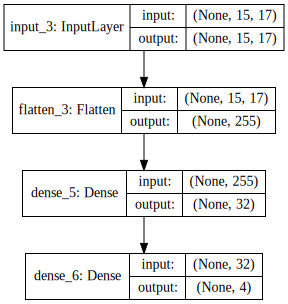

In [54]:
seed(2)
model_name ='mlp_1'

################ Naive model
x_input = Input(shape=(lookback,len(feature_cols)),dtype=float) # 5行4列的矩阵 
flt = Flatten()(x_input) # 拉平? 针对difference做prediction?
# BN1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(flt)
hid = Dense(latent_dim, activation='relu',kernel_regularizer=l2(0.005))(flt)
# BN2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(hid)
pred = Dense(len(target_cols), activation='linear')(hid) # 作为特征进行预测
model = Model(inputs=x_input, outputs=pred)


################ Compile & training
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)


################ evaluate
loss_mse, mae =  model.evaluate(x_test, y_test)
print("mae of four features in total", mae)
print("mse of four features in total", loss_mse)


################ prediction
y_p = model.predict(x_test)
mae_four = np.mean(np.abs(y_p - y_test),axis=0)
print("mae of four features separately \n", mae_four)
# model.summary()


Res_collect[model_name] = list(hstack([mae_four,mae])) + list(y_p.tolist())
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## MLP-2

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 0s 309us/step - loss: 3850070.8391 - mean_absolute_error: 1060.6996 - val_loss: 853070.2467 - val_mean_absolute_error: 535.0991
Epoch 2/20
1294/1294 [==============================] - 0s 108us/step - loss: 429352.2658 - mean_absolute_error: 409.7833 - val_loss: 591920.7739 - val_mean_absolute_error: 424.1320
Epoch 3/20
1294/1294 [==============================] - 0s 113us/step - loss: 388608.1256 - mean_absolute_error: 382.6496 - val_loss: 548962.3565 - val_mean_absolute_error: 417.1626
Epoch 4/20
1294/1294 [==============================] - 0s 111us/step - loss: 333086.4519 - mean_absolute_error: 352.4413 - val_loss: 468854.0072 - val_mean_absolute_error: 373.8539
Epoch 5/20
1294/1294 [==============================] - 0s 105us/step - loss: 285965.7991 - mean_absolute_error: 330.0461 - val_loss: 512645.3351 - val_mean_absolute_error: 390.5897
Epoch 6/20
1294/1294 [===================

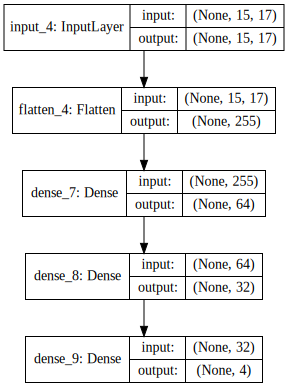

In [58]:
seed(2)
model_name='mlp_2'

################ Naive model
x_input = Input(shape=(lookback,len(feature_cols)),dtype=float) # 5行4列的矩阵 
flt = Flatten()(x_input) # 拉平? 针对difference做prediction?
# BN1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(flt)
hid = Dense(First_dim, activation='relu',kernel_regularizer=l2(0.015))(flt)
hid = Dense(latent_dim, activation='relu',kernel_regularizer=l2(0.015))(hid)
# BN2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(hid)
pred = Dense(len(target_cols), activation='linear')(hid) # 作为特征进行预测
model = Model(inputs=x_input, outputs=pred)


################ Compile & training
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)


################ evaluate
loss_mse, mae =  model.evaluate(x_test, y_test)
print("mae of four features in total", mae)
print("mse of four features in total", loss_mse)

################ prediction
y_p = model.predict(x_test)
mae_four = np.mean(np.abs(y_p - y_test),axis=0)
print("mae of four features separately \n", mae_four)
# model.summary()
Res_collect[model_name] = list(hstack([mae_four,mae])) + list(y_p.tolist())
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## MLP-3 Deep

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 2s 2ms/step - loss: 3419687.0711 - mean_absolute_error: 1047.5531 - val_loss: 629295.1414 - val_mean_absolute_error: 452.0535
Epoch 2/20
1294/1294 [==============================] - 0s 264us/step - loss: 559369.8405 - mean_absolute_error: 457.8944 - val_loss: 647218.7974 - val_mean_absolute_error: 484.7368
Epoch 3/20
1294/1294 [==============================] - 0s 259us/step - loss: 339074.4434 - mean_absolute_error: 360.9713 - val_loss: 471989.8779 - val_mean_absolute_error: 377.2498
Epoch 4/20
1294/1294 [==============================] - 0s 268us/step - loss: 223704.8700 - mean_absolute_error: 286.3775 - val_loss: 374190.8218 - val_mean_absolute_error: 347.3095
Epoch 5/20
1294/1294 [==============================] - 0s 266us/step - loss: 172802.6144 - mean_absolute_error: 260.4407 - val_loss: 262360.1193 - val_mean_absolute_error: 297.4068
Epoch 6/20
1294/1294 [=====================

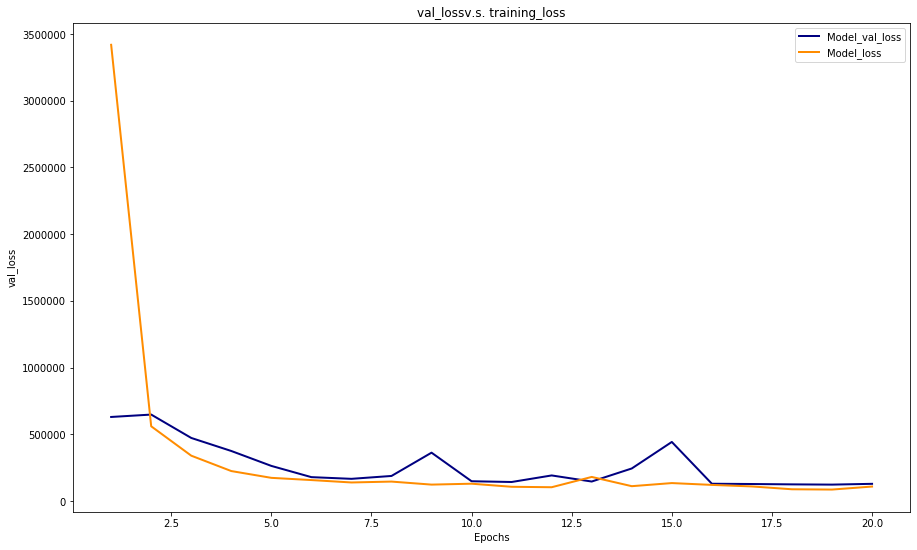

val_mean_absolute_error mean_absolute_error


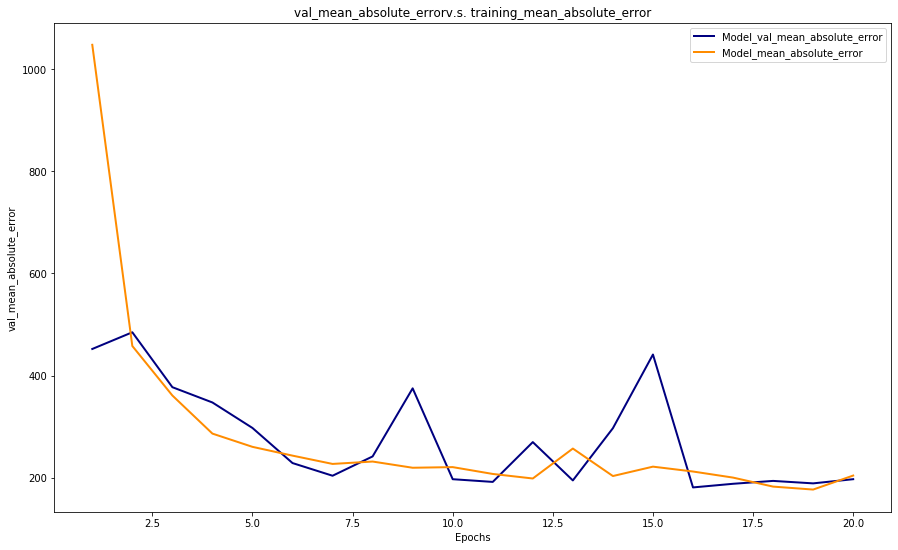

404/404 [==============================] - 0s 32us/step
mae of four features in total 202.4888822347811
mse of four features in total 143998.85751856436
mae of four features separately 
 [183.95053644 230.10046885 194.35212817 201.5523702 ]


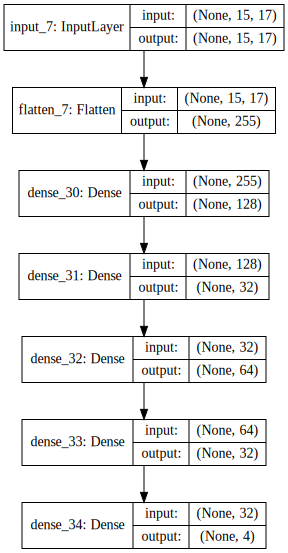

In [112]:
seed(2)
model_name='mlp_3'

################ Naive model
x_input = Input(shape=(lookback,len(feature_cols)),dtype=float) # 5X4 
flt = Flatten()(x_input) #
# BN1 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(flt)
hid = Dense(First_dim*2, activation='relu',kernel_regularizer=l2(0.015))(flt)
hid = Dense(latent_dim, activation='relu',kernel_regularizer=l2(0.015))(hid)
hid = Dense(latent_dim*2, activation='relu',kernel_regularizer=l2(0.015))(hid)
hid = Dense(latent_dim, activation='relu',kernel_regularizer=l2(0.015))(hid)
# BN2 = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(hid)
pred = Dense(len(target_cols), activation='linear')(hid) 
model = Model(inputs=x_input, outputs=pred)


################ Compile & training
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, shuffle=True, verbose=1)
################ evaluate
history_plot(history)
loss_mse, mae =  model.evaluate(x_test, y_test)
print("mae of four features in total", mae)
print("mse of four features in total", loss_mse)

################ prediction
y_p = model.predict(x_test)
mae_four = np.mean(np.abs(y_p - y_test),axis=0)
print("mae of four features separately \n", mae_four)
# model.summary()
Res_collect[model_name] = list(hstack([mae_four,mae])) + list(y_p.tolist())
SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# RNNs

In [60]:
# Define a function to train model, 
# plot training history, and 
# calculate testing performance
from keras.callbacks import EarlyStopping, ModelCheckpoint





def history_plot(training):
    
    ################## plot training history
#     dic = ['val_loss', 'loss', 'val_acc', 'acc', "val_auroc"] # print(training.history)
#     loss: 0.8109 - acc: 0.6362 - auroc: 0.7960 - val_loss: 0.6793 - val_acc: 0.7144 - val_auroc: 0.8684
    dic = list(training.history.keys())
    idx = [[0,2],[1,3]]
    
    for i,j in idx:
        print("========================================================================")
        print(dic[i],dic[j])
        xx = list(range(1,len(training.history[dic[i]])+1))

        plt.plot(xx,training.history[dic[i]], color = 'navy', lw = 2, label = 'Model_'+str(dic[i]))
        plt.plot(xx,training.history[dic[j]], color = 'darkorange', lw = 2, label = 'Model_'+str(dic[j]))

        plt.title(str(dic[i]) + "v.s. training_" + str(dic[j]))
        plt.xlabel('Epochs')
        plt.ylabel(str(dic[i]))
        plt.legend()
        plt.show();

    return None


def train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, Res_collect, BestModel_Name="mlp_1" , ):
    
    
    #### Best model selection 
    patience=30
    BEST_MODEL_FILEPATH = BestModel_Name+'.h5'
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
    checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)
    model.load_weights(BestModel_Name+'.h5')

    
    #### Result
    history_plot(history)

    ################## evaluation
    y_pred = model.predict(x_test)
    loss_mse, mae =  model.evaluate(x_test, y_test)
    print("mae of four features in total", mae)
    print("mae of four features in total", loss_mse)
    y_pred = model.predict(x_test)
    mae_four = np.mean(np.abs(y_pred-y_test), axis=0)
    print("mae of four features separately \n", mae_four)

    
    Res_collect[BestModel_Name] = list(hstack([mae_four,mae])) + list(y_pred.tolist())
    return y_pred, Res_collect # 也许能出 tpr 和 fpr图

## SimpleRNN


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


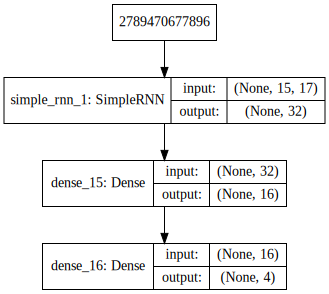

In [61]:
model = Sequential()
model.add(SimpleRNN(latent_dim,activation='tanh',use_bias=True,
               dropout=0.0, recurrent_dropout=0.2, input_shape = (lookback,len(feature_cols)),
               return_sequences=False, return_state=False))
model.add(Dense(len(target_cols)*4, activation='relu')) 
model.add(Dense(len(target_cols), activation='linear')) 

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# rmsprop = optimizers.rmsprop(lr=1e-3)
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 1s 746us/step - loss: 22119707.5529 - mean_absolute_error: 3607.6774 - val_loss: 16032985.9630 - val_mean_absolute_error: 3375.1609
Epoch 2/20
1294/1294 [==============================] - 0s 353us/step - loss: 9863805.3733 - mean_absolute_error: 2549.2198 - val_loss: 5901450.2346 - val_mean_absolute_error: 1699.7492
Epoch 3/20
1294/1294 [==============================] - 0s 355us/step - loss: 4944249.8049 - mean_absolute_error: 1529.0398 - val_loss: 3220066.1597 - val_mean_absolute_error: 1138.4363
Epoch 4/20
1294/1294 [==============================] - 0s 349us/step - loss: 2867023.1308 - mean_absolute_error: 1122.2281 - val_loss: 1768243.4045 - val_mean_absolute_error: 705.1834
Epoch 5/20
1294/1294 [==============================] - 0s 352us/step - loss: 1754649.0698 - mean_absolute_error: 816.8716 - val_loss: 1308588.2874 - val_mean_absolute_error: 611.1388
Epoch 6/20
1294/1294 [==

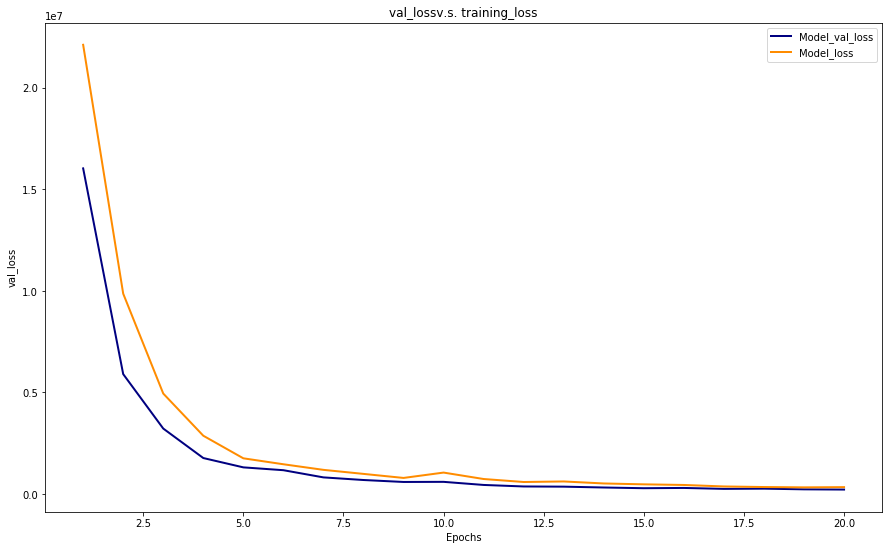

val_mean_absolute_error mean_absolute_error


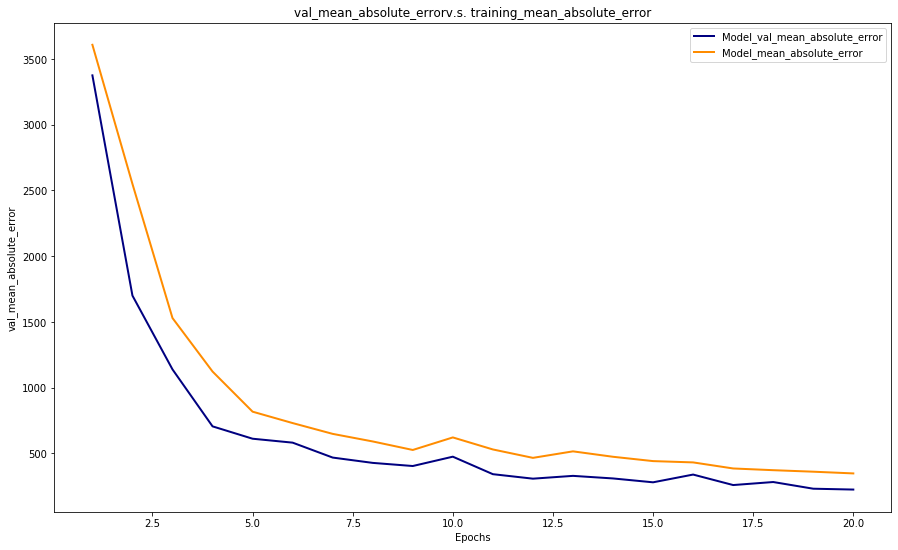

404/404 [==============================] - 0s 37us/step
mae of four features in total 203.16518349222616
mae of four features in total 203782.04749381187
mae of four features separately 
 [173.40965754 207.55936696 211.60948872 220.08221817]


In [62]:
y_pred, Res_collect = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='simple_rnn')

## GRU

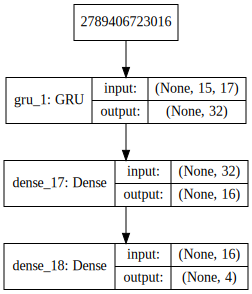

In [63]:
model = Sequential()
# model.add(Input(shape=(lookback,len(feature_cols)),dtype=float)) # 5行4列的矩阵 
model.add(GRU(latent_dim,activation='tanh',recurrent_activation='sigmoid',use_bias=True,
               dropout=0.0, recurrent_dropout=0.2, input_shape = (lookback,len(feature_cols)),
               return_sequences=False, return_state=False))
model.add(Dense(len(target_cols)*4, activation='relu')) 
model.add(Dense(len(target_cols), activation='linear')) 

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# rmsprop = optimizers.rmsprop(lr=1e-3)
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 

SVG(model_to_dot(model,show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 2s 1ms/step - loss: 24986955.5116 - mean_absolute_error: 3653.6214 - val_loss: 19514848.3580 - val_mean_absolute_error: 3649.2252
Epoch 2/20
1294/1294 [==============================] - 1s 875us/step - loss: 15913633.7836 - mean_absolute_error: 3413.6725 - val_loss: 16842649.5062 - val_mean_absolute_error: 3548.4614
Epoch 3/20
1294/1294 [==============================] - 1s 858us/step - loss: 7793517.9225 - mean_absolute_error: 1855.0707 - val_loss: 4937864.4861 - val_mean_absolute_error: 1168.8290
Epoch 4/20
1294/1294 [==============================] - 1s 863us/step - loss: 3044355.7673 - mean_absolute_error: 938.6637 - val_loss: 2617427.5721 - val_mean_absolute_error: 762.8910
Epoch 5/20
1294/1294 [==============================] - 1s 882us/step - loss: 1899591.2362 - mean_absolute_error: 717.3881 - val_loss: 1740281.2795 - val_mean_absolute_error: 627.9684
Epoch 6/20
1294/1294 [===

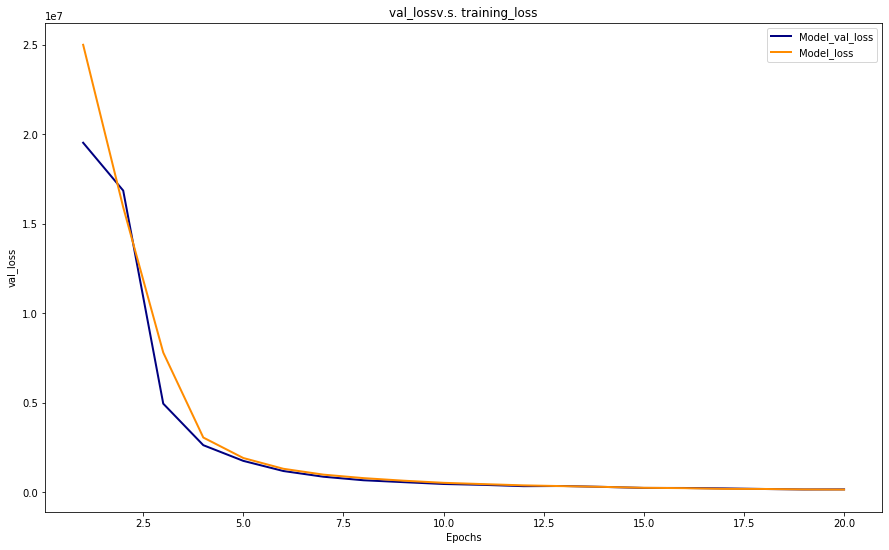

val_mean_absolute_error mean_absolute_error


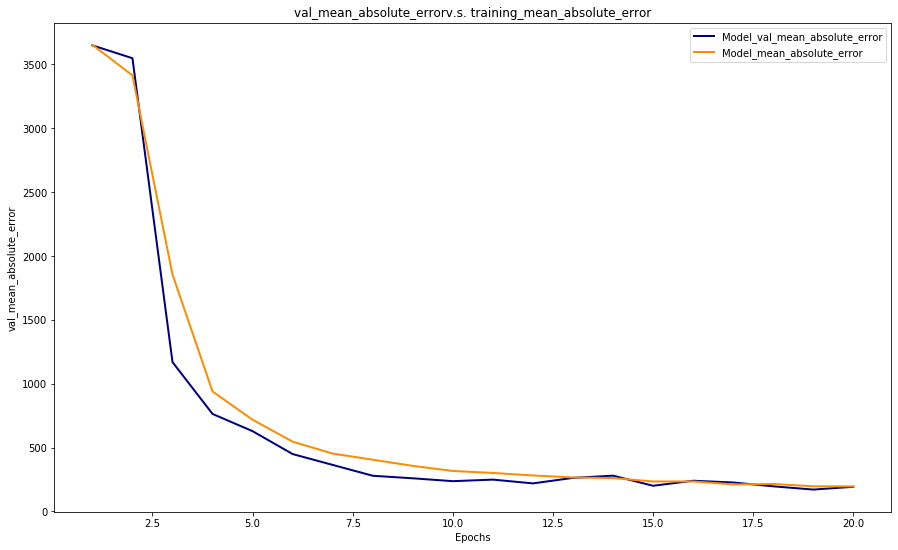

404/404 [==============================] - 0s 47us/step
mae of four features in total 151.75924335139814
mae of four features in total 136708.73754641088
mae of four features separately 
 [119.32455898 158.45423647 157.56835741 171.689819  ]


In [64]:
y_pred, Res_collect = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='gru')

## LSTM

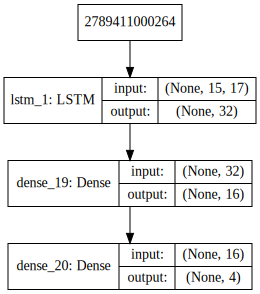

In [65]:
model = Sequential()
# model.add(Input(shape=(lookback,len(feature_cols)),dtype=float)) # 5行4列的矩阵 
model.add(LSTM(latent_dim,activation='tanh',recurrent_activation='sigmoid',use_bias=True,
               dropout=0.0, recurrent_dropout=0.2, input_shape = (lookback,len(feature_cols)),
               return_sequences=False, return_state=False))
model.add(Dense(len(target_cols)*4, activation='relu')) 
model.add(Dense(len(target_cols), activation='linear')) 

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# rmsprop = optimizers.rmsprop(lr=1e-3)
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 2s 2ms/step - loss: 24697923.7867 - mean_absolute_error: 3689.7269 - val_loss: 19635616.5309 - val_mean_absolute_error: 3648.4948
Epoch 2/20
1294/1294 [==============================] - 1s 1ms/step - loss: 15235192.5131 - mean_absolute_error: 3251.1420 - val_loss: 10870865.4637 - val_mean_absolute_error: 2022.2871
Epoch 3/20
1294/1294 [==============================] - 1s 997us/step - loss: 5708332.5523 - mean_absolute_error: 1361.6349 - val_loss: 3977664.0193 - val_mean_absolute_error: 1010.6011
Epoch 4/20
1294/1294 [==============================] - 1s 978us/step - loss: 2441896.8198 - mean_absolute_error: 769.4187 - val_loss: 2198942.0738 - val_mean_absolute_error: 682.2342
Epoch 5/20
1294/1294 [==============================] - 1s 968us/step - loss: 1576358.2885 - mean_absolute_error: 600.5658 - val_loss: 1393301.7174 - val_mean_absolute_error: 513.7080
Epoch 6/20
1294/1294 [=====

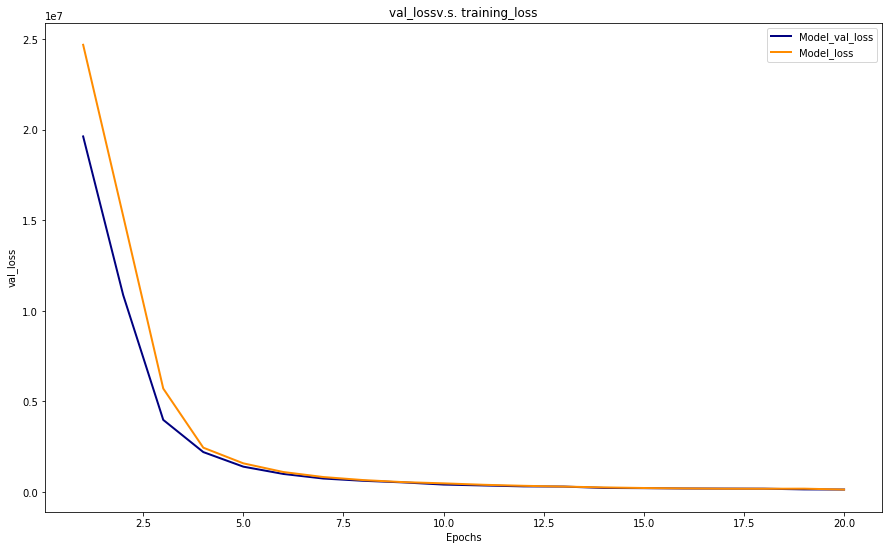

val_mean_absolute_error mean_absolute_error


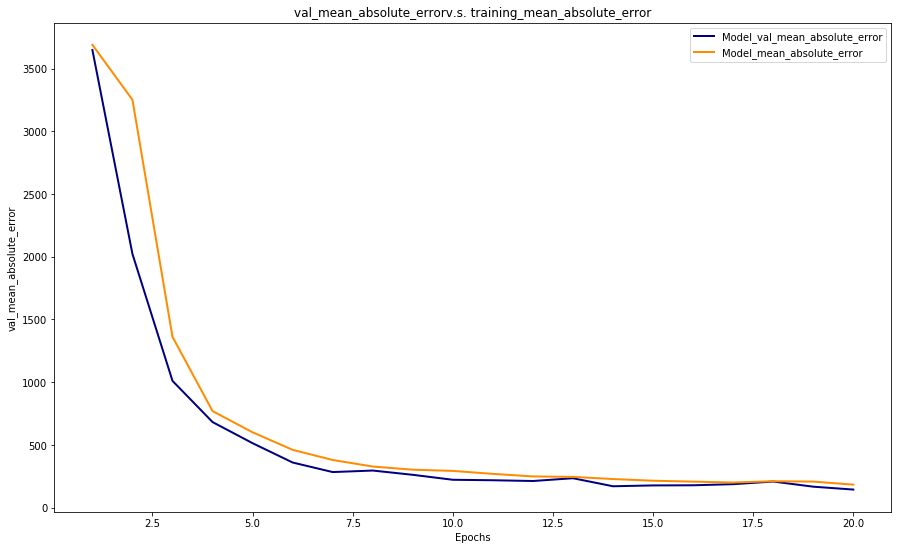

404/404 [==============================] - 0s 57us/step
mae of four features in total 124.84775037104541
mae of four features in total 122891.53221689357
mae of four features separately 
 [ 82.4961918  127.61795784 137.3569972  151.91984868]


In [66]:
y_pred, Res_collect = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='lstm')

## Bidirectional LSTM

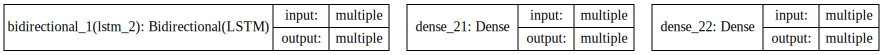

In [67]:
model = Sequential()
# model.add(Input(shape=(lookback,len(feature_cols)),dtype=float)) # 5行4列的矩阵 
model.add(Bidirectional(LSTM(latent_dim,activation='tanh',recurrent_activation='sigmoid',use_bias=True,
               dropout=0.0, recurrent_dropout=0.2, input_shape = (lookback,len(feature_cols)),
               return_sequences=False, return_state=False)))
model.add(Dense(len(target_cols)*4, activation='relu')) 
model.add(Dense(len(target_cols), activation='linear')) 


# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# rmsprop = optimizers.rmsprop(lr=1e-3)
model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 3s 3ms/step - loss: 20760911.8053 - mean_absolute_error: 3549.5635 - val_loss: 17777828.1481 - val_mean_absolute_error: 3709.7358
Epoch 2/20
1294/1294 [==============================] - 2s 1ms/step - loss: 14145013.4193 - mean_absolute_error: 3172.4029 - val_loss: 8396432.1123 - val_mean_absolute_error: 1752.9925
Epoch 3/20
1294/1294 [==============================] - 2s 1ms/step - loss: 3590124.9536 - mean_absolute_error: 1062.1749 - val_loss: 2146374.2859 - val_mean_absolute_error: 732.6653
Epoch 4/20
1294/1294 [==============================] - 2s 1ms/step - loss: 1533704.2117 - mean_absolute_error: 647.1961 - val_loss: 1296618.6273 - val_mean_absolute_error: 553.1862
Epoch 5/20
1294/1294 [==============================] - 2s 1ms/step - loss: 1002228.2923 - mean_absolute_error: 515.4492 - val_loss: 721551.7372 - val_mean_absolute_error: 326.7099
Epoch 6/20
1294/1294 [==============

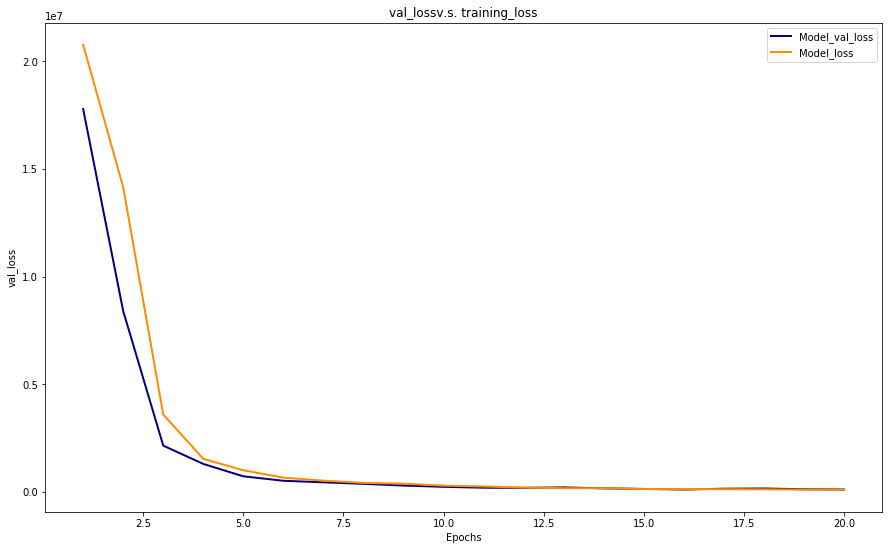

val_mean_absolute_error mean_absolute_error


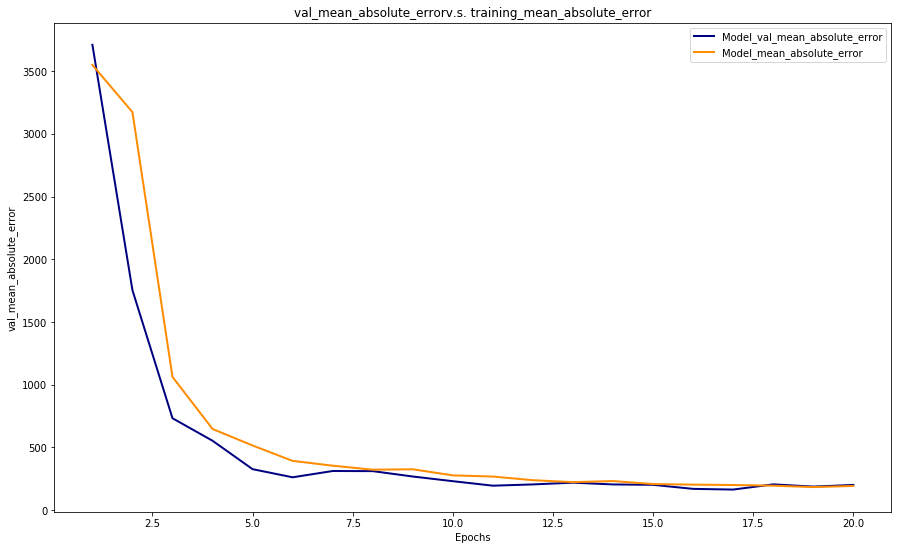

404/404 [==============================] - 0s 64us/step
mae of four features in total 154.7984424251141
mae of four features in total 113572.91530012376
mae of four features separately 
 [119.84913949 157.68838973 163.70373173 177.95250785]


In [68]:
y_pred, Res_collect = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='bidirection_lstm')

## Bidirectional GRU

In [69]:

def naive_birnn(First_dim, latent_dim):
    model = Sequential()
    # model.add(Input(shape=(lookback,len(feature_cols)),dtype=float)) # 5行4列的矩阵 
    model.add(Bidirectional(GRU(First_dim, activation='tanh',recurrent_activation='sigmoid', dropout=0, input_shape = (lookback,len(feature_cols)), return_sequences=True)))
    model.add(Bidirectional(GRU(latent_dim, activation='tanh',recurrent_activation='sigmoid', dropout=0, return_sequences=False)))
    # model.add(LSTM(40,activation='relu',recurrent_activation='sigmoid',use_bias=True,
    #                dropout=0, recurrent_dropout=0.2, return_sequences=False, return_state=False))

    model.add(Dense(len(target_cols), activation='linear')) 


    ################## compile and fit model
    print("@"*10," "*5, model.get_config()['name']," Processing"," "*5,"@"*10)
    # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.adam(lr=0.0005)
    # rmsprop = optimizers.rmsprop(lr=1e-3)
    model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 
    return model


@@@@@@@@@@       sequential_6  Processing       @@@@@@@@@@
Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 4s 3ms/step - loss: 32837112.2968 - mean_absolute_error: 4155.3031 - val_loss: 35637536.4938 - val_mean_absolute_error: 4226.5313
Epoch 2/20
1294/1294 [==============================] - 2s 2ms/step - loss: 32784781.3849 - mean_absolute_error: 4148.9069 - val_loss: 35592462.4321 - val_mean_absolute_error: 4221.1935
Epoch 3/20
1294/1294 [==============================] - 2s 2ms/step - loss: 32741215.2859 - mean_absolute_error: 4143.6344 - val_loss: 35548327.5679 - val_mean_absolute_error: 4215.9618
Epoch 4/20
1294/1294 [==============================] - 2s 2ms/step - loss: 32698424.7403 - mean_absolute_error: 4138.4997 - val_loss: 35505346.3951 - val_mean_absolute_error: 4210.8609
Epoch 5/20
1294/1294 [==============================] - 2s 2ms/step - loss: 32656227.9606 - mean_absolute_error: 4133.4054 - val_loss: 35462404.7531 -

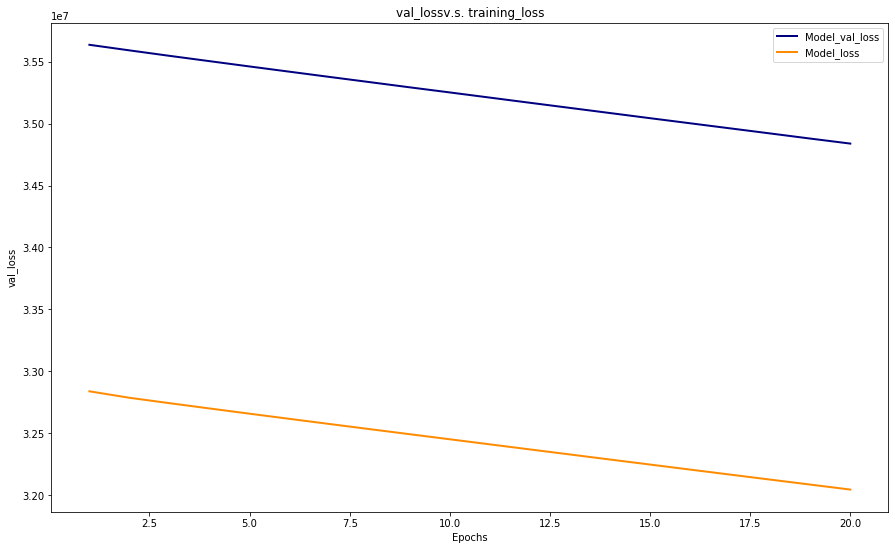

val_mean_absolute_error mean_absolute_error


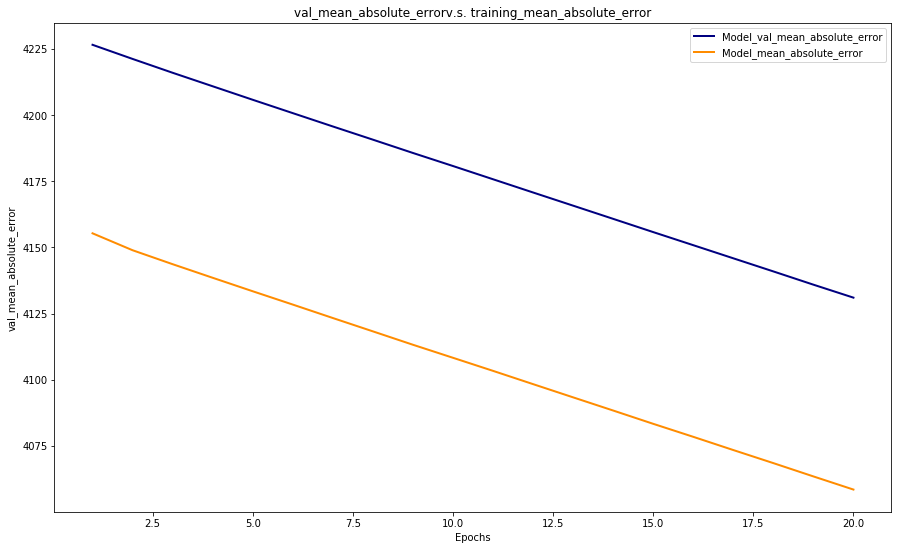

404/404 [==============================] - 0s 114us/step
mae of four features in total 3791.4490592125617
mae of four features in total 29901785.069306932
mae of four features separately 
 [3788.65504739 3899.69841825 3675.25556632 3802.18732205]


In [70]:
# # Train the model
bid_model = naive_birnn(First_dim, latent_dim)
y_pred, Res_collect = train_model(bid_model, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='bidirection_gru')


## Multi-layers RNN

@@@@@@@@@@       sequential_7  Processing       @@@@@@@@@@
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1294 samples, validate on 324 samples
Epoch 1/20
1294/1294 [==============================] - 5s 4ms/step - loss: 23211974.3246 - mean_absolute_error: 3433.0727 - val_loss: 12552381.1265 - val_mean_absolute_error: 2694.9011
Epoch 2/20
1294/1294 [==============================] - 3s 2ms/step - loss: 15287719.2898 - mean_absolute_error: 2820.6200 - val_loss: 10073189.0031 - val_mean_absolute_error: 2414.3031
Epoch 3/20
1294/1294 [==============================] - 3s 2ms/step - loss: 12752272.1043 - mean_absolute_error: 2591.4926 - val_loss: 11917483.2562 - val_mean_absolute_error: 2504.1241
Epoch 4/20
1294/1294 [==============================] - 3s 2ms/step - loss: 12719439.7485 - mean_absolute_error: 2515.7956 - val_loss: 10151211.9290 - val_mean_absolute_error: 2319.7718
Epoch 5/20
1294/1294 [==============================] - 

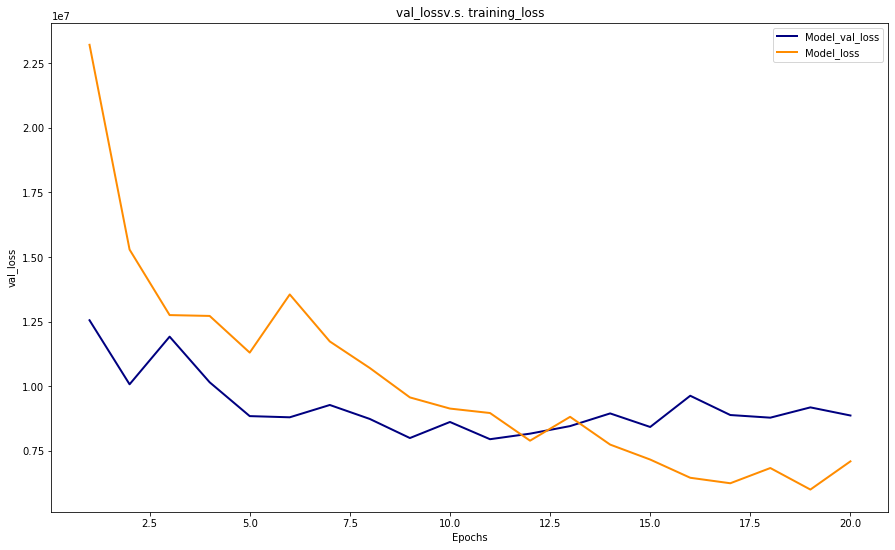

val_mean_absolute_error mean_absolute_error


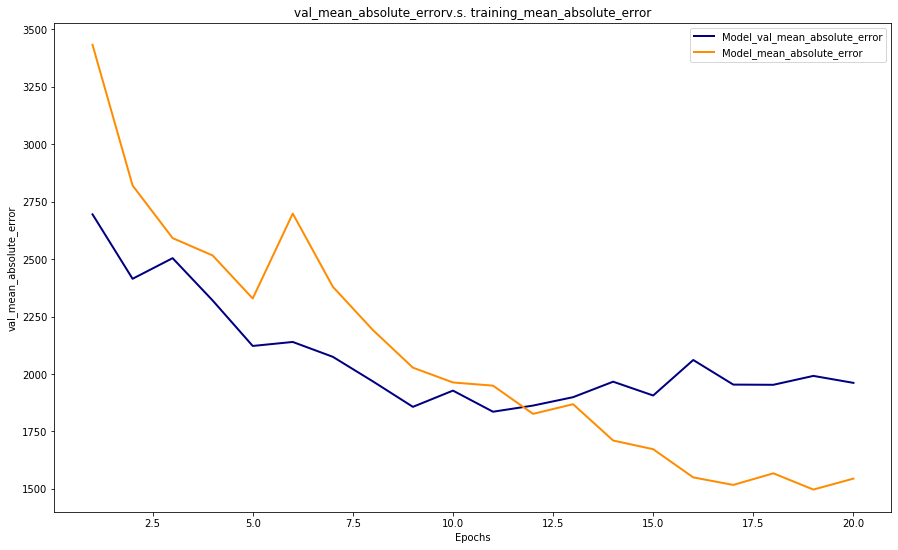

404/404 [==============================] - 0s 114us/step
mae of four features in total 1631.0389609761758
mae of four features in total 6467685.311881188
mae of four features separately 
 [1624.97432728 1649.02280743 1540.39285539 1709.76589233]


In [71]:

def birnn1(First_dim, latent_dim):
    model = Sequential()
    # model.add(Input(shape=(lookback,len(feature_cols)),dtype=float)) # 5行4列的矩阵 
    model.add(Bidirectional(GRU(First_dim, activation='tanh',dropout=0, input_shape = (lookback,len(feature_cols)), return_sequences=True)))
#     model.add(Bidirectional(GRU(128, activation='tanh',dropout=0, return_sequences=False)))
    model.add(LSTM(latent_dim,activation='relu',recurrent_activation='sigmoid',use_bias=True,
                   dropout=0, recurrent_dropout=0.2, return_sequences=False, return_state=False))

    model.add(Dense(len(target_cols), activation='linear')) 


    ################## compile and fit model
    print("@"*10," "*5, model.get_config()['name']," Processing"," "*5,"@"*10)
    # sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.adam(lr=0.0005)
    # rmsprop = optimizers.rmsprop(lr=1e-3)
    model.compile(loss="mse", optimizer=adam, metrics=["mae"]) 
    return model

birnn1_mod = birnn1(First_dim, latent_dim)
y_pred, Res_collect = train_model(birnn1_mod, x_train, y_train, x_test, y_test, BATCH_SIZE=batch_size, NUM_EPOCHES=epochs, Res_collect=Res_collect, BestModel_Name='multi_layer_rnn')

In [89]:
table = Res_collect.iloc[0:5,:].T
table.columns = ['Pred_'+i + "_mae"for i in target_cols] + ['Total mae']
table.sort_values(by='Total mae', ascending=True)

,Pred_open_mae,Pred_high_mae,Pred_low_mae,Pred_close_mae,Total mae
lstm,82.4962,127.618,137.357,151.92,124.848
gru,119.325,158.454,157.568,171.69,151.759
bidirection_lstm,119.849,157.688,163.704,177.953,154.798
mlp_3,179.357,226.025,191.81,200.924,199.529
simple_rnn,173.41,207.559,211.609,220.082,203.165
mlp_2,197.408,233.337,248.67,253.471,233.221
naive_ma,346.614,354.665,331.64,337.974,342.723
mlp_1,357.999,376.984,396.481,394.53,381.498
multi_layer_rnn,1624.97,1649.02,1540.39,1709.77,1631.04
bidirection_gru,3788.66,3899.7,3675.26,3802.19,3791.45


# N.0 <font color =red ># Corr Analysis For time series See another file </font>

# N.0  <font color =red > Trading policy</font>